In [1]:
import warnings
warnings.filterwarnings('ignore')

#General Data/Plotting
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from tqdm.auto import tqdm 
import random

# Language
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from nltk.tokenize import word_tokenize

import re 
from collections import Counter
from string import punctuation

# Modeling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dense , Embedding , Bidirectional , LSTM

lemma = WordNetLemmatizer()

In [2]:
# read dataset and save it into df variable
df = pd.read_json('../Datasets/Cell_Phones_and_Accessories_5.json', lines=True)

# rename columns for better understanding
df = df.rename(columns={"reviewText":"Review","overall": "Rating","summary":"Title"})

# drop unessesary data
df.drop(['reviewerID', 'asin', 'reviewerName', 'unixReviewTime', 'reviewTime'], axis='columns', inplace=True)

# split the helpful tuple into two new rows
df['helpful_0'] = df['helpful'].apply(func=lambda x: x[0])
df['helpful_1'] = df['helpful'].apply(func=lambda x: x[1])

# number of reviews
print("Number of Datapoints: ", len(df))

Number of Datapoints:  194439


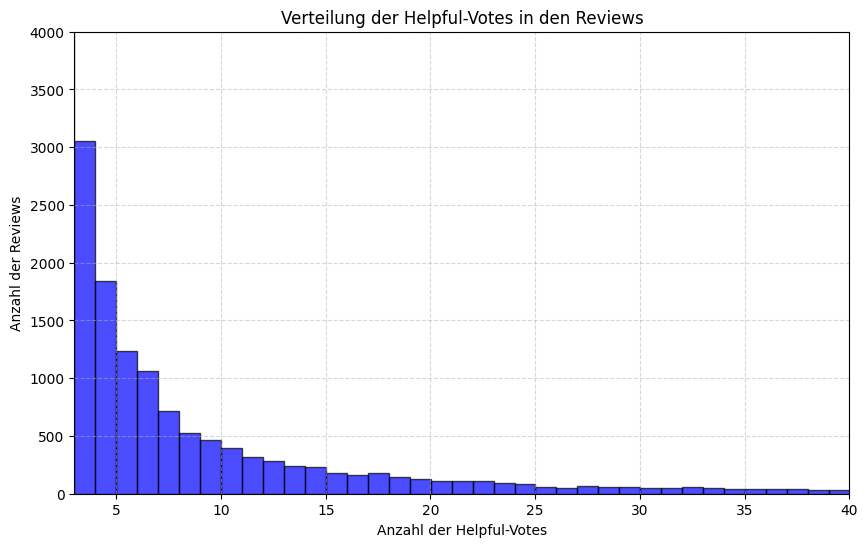

In [3]:
# Verteilung der Bewertungen unter den Reviews
# Plot erstellen
plt.figure(figsize=(10, 6))
plt.hist(df['helpful_1'], bins=2030, color='blue', edgecolor='black', alpha=0.7, density=False)

# Titel und Beschriftungen hinzufügen
plt.title('Verteilung der Helpful-Votes in den Reviews')
plt.xlabel('Anzahl der Helpful-Votes')
plt.ylabel('Anzahl der Reviews')

# Gitter hinzufügen
plt.grid(True, linestyle='--', alpha=0.5)
plt.ylim(0, 4000)  # Hier kannst du den Bereich anpassen
plt.xlim(3, 40)

# Diagramm anzeigen
plt.show()

In [4]:
# Remove Reviews that have less than 3 helpful votes
df = df[df['helpful_1'] >= 3]

# add calculation of helpfullness ration and convert it to an int percentage
df['helpful_ratio'] = df['helpful_0'] / df['helpful_1']
df['ratio_percent'] = (df['helpful_ratio'] * 100).astype(int)

# remove helpfullness ratio
df.drop(['helpful_ratio'], axis='columns', inplace=True)

# calculate length of reviews in new column
df['review_len'] = [len(text.split()) for text in df.Review]

# classify reviews with a ratio_percent over 70% as helpful
def convert_label(df) : 
    if df['ratio_percent'] <= 70 : 
        rate = 0 # for Negative 
    else : 
        rate = 1 # for Positive
        
    return rate

df['IsHelpful'] = df.apply(convert_label, axis = 1)


# number of reviews
print("Number of Datapoints after preprocessing: ", len(df))

Number of Datapoints after preprocessing:  18284


In [5]:
# prepare review text for further processing
def DataPrep(text) : 
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    # tokenization 
    tokens = nltk.word_tokenize(text) 
    
    # remove puncs 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    
    # remove stopwords 
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    
    # lemmatization 
    words = [lemma.lemmatize(word) for word in words]
    
    text = ' '.join(words)
    
    return text

df['cleaned_reviews'] = df['Review'].apply(DataPrep)
print(f'{int(df["cleaned_reviews"].duplicated().sum())} duplicated reviews are removed.')
df.drop_duplicates("cleaned_reviews", inplace=True)

76 duplicated reviews are removed.


In [7]:
# export to new json
df.to_json('../Datasets/Modified_Phones_rating.json', index=False)